# RNN and Dijkstra Implementation for Robot Path Planning

This notebook implements an encoder-decoder RNN for predicting robot movement and Dijkstra's algorithm for path planning. It includes visualizations of loss curves and comparisons between actual and predicted paths.

Author: Autonomous Programmer


## 1. Imports and Configuration


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
import pickle
import matplotlib.pyplot as plt
import math
import heapq
from collections import deque
import os
import time


In [2]:
# === Configuration ===
SEQ_LEN = 20
EPOCHS = 30
BATCH_SIZE = 32
LR = 0.001
INPUT_FEATURES = ['x', 'y', 'lin_vel', 'ang_vel', 'cmd_lin_x', 'cmd_ang_z']
TARGET_FEATURES = ['x', 'y']

# Dijkstra configuration
GRID_RESOLUTION = 0.1  # meters per cell
GRID_WIDTH = 200  # cells
GRID_HEIGHT = 200  # cells
OBSTACLE_THRESHOLD = 0.3  # meters
MAX_LINEAR_SPEED = 0.22  # m/s
MAX_ANGULAR_SPEED = 2.0  # rad/s


## 2. Data Loading and Preprocessing


In [4]:
# Load data
# Update the path to your aligned_data.csv file
data_path = "/Users/aditya/PycharmProjects/Ros2-RNN/Ros2-RNN/RNN's/aligned_data.csv"
df = pd.read_csv(data_path)

# Display the first few rows
df.head()


,using time,x,y,lin_vel,ang_vel,cmd_lin_x,cmd_ang_z
0,1.746638e+09,-0.483882,-0.500002,0.150002,-2.884031e-08,0.15,0.0
1,1.746638e+09,-0.478782,-0.500002,0.150004,-8.847759e-10,0.15,0.0
2,1.746638e+09,-0.453281,-0.500002,0.150001,-4.012190e-08,0.15,0.0
3,1.746638e+09,-0.422682,-0.500002,0.150004,-1.100738e-07,0.15,0.0
4,1.746638e+09,-0.417581,-0.500002,0.150005,-1.172784e-07,0.15,0.0


In [5]:
# Normalize data
scaler = MinMaxScaler()
scaled_inputs = scaler.fit_transform(df[INPUT_FEATURES])

# Save the scaler for later use
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("Scaler saved to scaler.pkl")


Scaler saved to scaler.pkl


## 3. Dataset Creation


In [6]:
class SequenceDataset(Dataset):
    def __init__(self, inputs, raw_targets, seq_len):
        self.inputs = inputs
        self.targets = raw_targets
        self.seq_len = seq_len

    def __len__(self):
        return len(self.inputs) - self.seq_len

    def __getitem__(self, idx):
        x_seq = self.inputs[idx:idx + self.seq_len]
        y = self.targets.iloc[idx + self.seq_len][TARGET_FEATURES].values
        return torch.tensor(x_seq, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Create dataset and dataloader
dataset = SequenceDataset(scaled_inputs, df, SEQ_LEN)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"Dataset size: {len(dataset)}")
print(f"Number of batches: {len(loader)}")


Dataset size: 2801
Number of batches: 88


## 4. RNN Model Implementation


In [8]:
class Encoder(nn.Module):
    """
    LSTM Encoder for the sequence-to-one architecture.

    Takes a sequence of robot states and encodes it into a hidden state.
    """
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        """
        Initialize the encoder.

        Args:
            input_size: Number of features in the input
            hidden_size: Size of the hidden state
            num_layers: Number of LSTM layers
        """
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)

    def forward(self, x):
        """
        Forward pass through the encoder.

        Args:
            x: Input tensor of shape (batch_size, seq_len, input_size)

        Returns:
            h_n: Final hidden state
            c_n: Final cell state
        """
        _, (h_n, c_n) = self.lstm(x)
        return h_n, c_n

class Decoder(nn.Module):
    """
    Linear Decoder for the sequence-to-one architecture.

    Takes the hidden state from the encoder and produces the output.
    """
    def __init__(self, hidden_size=64, output_size=2):
        """
        Initialize the decoder.

        Args:
            hidden_size: Size of the hidden state from the encoder
            output_size: Number of features in the output
        """
        super().__init__()
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, h):
        """
        Forward pass through the decoder.

        Args:
            h: Hidden state from the encoder

        Returns:
            Output tensor
        """
        return self.fc(h[-1])

class Seq2One(nn.Module):
    """
    Sequence-to-One model combining the encoder and decoder.

    Takes a sequence of robot states and predicts the next position.
    """
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        """
        Initialize the sequence-to-one model.

        Args:
            input_size: Number of features in the input
            hidden_size: Size of the hidden state
            num_layers: Number of LSTM layers
        """
        super().__init__()
        self.encoder = Encoder(input_size, hidden_size, num_layers)
        self.decoder = Decoder(hidden_size, output_size=2)

    def forward(self, x):
        """
        Forward pass through the sequence-to-one model.

        Args:
            x: Input tensor of shape (batch_size, seq_len, input_size)

        Returns:
            Output tensor
        """
        h_n, c_n = self.encoder(x)
        return self.decoder(h_n)


In [9]:
# Initialize model, loss function, and optimizer
model = Seq2One(input_size=len(INPUT_FEATURES))
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

print("Model initialized")


Model initialized


## 5. Model Training


In [10]:
# Training loop
losses = []
predicted_xy = []
true_xy = []

start_time = time.time()

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for batch_x, batch_y in loader:
        pred = model(batch_x)
        loss = criterion(pred, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        if epoch == EPOCHS - 1:
            predicted_xy.extend(pred.detach().numpy())
            true_xy.extend(batch_y.detach().numpy())

    losses.append(epoch_loss / len(loader))
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {losses[-1]:.4f}")

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")


Epoch 1/30 | Loss: 0.7351
Epoch 2/30 | Loss: 0.0234
Epoch 3/30 | Loss: 0.0109
Epoch 4/30 | Loss: 0.0091
Epoch 5/30 | Loss: 0.0084
Epoch 6/30 | Loss: 0.0074
Epoch 7/30 | Loss: 0.0066
Epoch 8/30 | Loss: 0.0058
Epoch 9/30 | Loss: 0.0053
Epoch 10/30 | Loss: 0.0052
Epoch 11/30 | Loss: 0.0039
Epoch 12/30 | Loss: 0.0033
Epoch 13/30 | Loss: 0.0030
Epoch 14/30 | Loss: 0.0029
Epoch 15/30 | Loss: 0.0022
Epoch 16/30 | Loss: 0.0026
Epoch 17/30 | Loss: 0.0021
Epoch 18/30 | Loss: 0.0017
Epoch 19/30 | Loss: 0.0014
Epoch 20/30 | Loss: 0.0014
Epoch 21/30 | Loss: 0.0011
Epoch 22/30 | Loss: 0.0015
Epoch 23/30 | Loss: 0.0011
Epoch 24/30 | Loss: 0.0010
Epoch 25/30 | Loss: 0.0010
Epoch 26/30 | Loss: 0.0009
Epoch 27/30 | Loss: 0.0008
Epoch 28/30 | Loss: 0.0011
Epoch 29/30 | Loss: 0.0011
Epoch 30/30 | Loss: 0.0009
Training completed in 19.74 seconds


## 6. Loss Curve Visualization


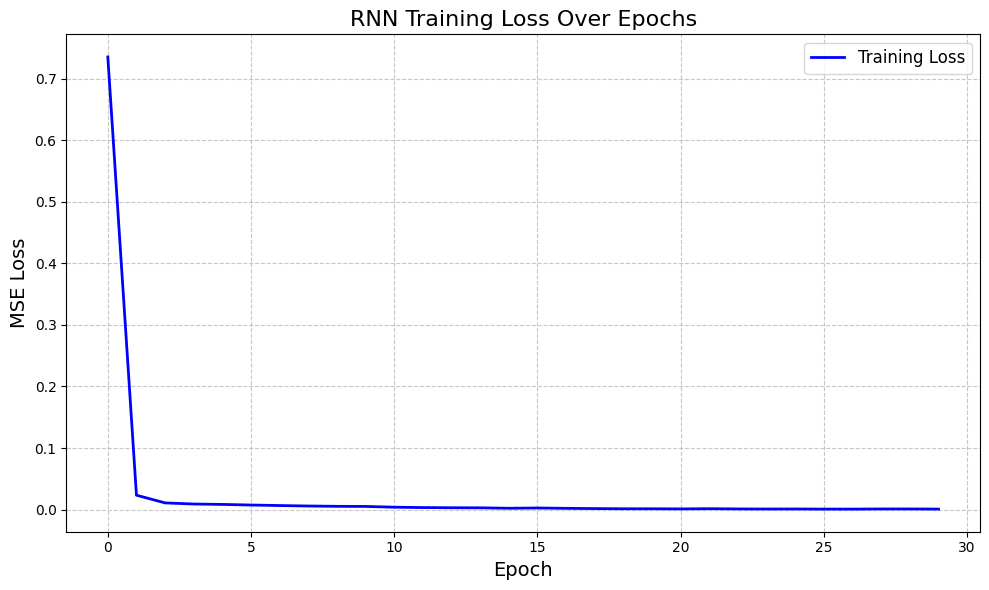

In [11]:
# Plot loss curve
plt.figure(figsize=(10, 6))
plt.plot(losses, label="Training Loss", color='blue', linewidth=2)
plt.title("RNN Training Loss Over Epochs", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("MSE Loss", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig("rnn_loss_curve.png", dpi=300)
plt.show()


## 7. Dijkstra's Algorithm Implementation


In [14]:
class DijkstraPlanner:
    """
    Path planner using Dijkstra's algorithm.

    Plans a path from the current position to a goal position
    while avoiding obstacles.
    """
    def __init__(self, resolution=GRID_RESOLUTION, width=GRID_WIDTH, height=GRID_HEIGHT):
        """
        Initialize the Dijkstra planner.

        Args:
            resolution: Grid resolution in meters per cell
            width: Grid width in cells
            height: Grid height in cells
        """
        self.resolution = resolution
        self.width = width
        self.height = height
        self.grid = np.zeros((height, width), dtype=np.int8)
        self.origin_x = -width * resolution / 2
        self.origin_y = -height * resolution / 2

    def update_grid(self, obstacles):
        """
        Update the occupancy grid based on obstacle positions.

        Args:
            obstacles: List of (x, y) coordinates of obstacles
        """
        # Clear the grid
        self.grid = np.zeros((self.height, self.width), dtype=np.int8)

        # Mark obstacles on the grid
        for obstacle_x, obstacle_y in obstacles:
            # Convert to grid coordinates
            obstacle_grid_x, obstacle_grid_y = self.world_to_grid(obstacle_x, obstacle_y)

            # Check if the coordinates are within the grid
            if 0 <= obstacle_grid_x < self.width and 0 <= obstacle_grid_y < self.height:
                # Mark the cell as occupied
                self.grid[obstacle_grid_y, obstacle_grid_x] = 100

                # Inflate obstacles for safety
                self.inflate_obstacle(obstacle_grid_x, obstacle_grid_y, int(OBSTACLE_THRESHOLD / self.resolution))

    def inflate_obstacle(self, x, y, radius):
        """
        Inflate an obstacle to ensure the robot keeps a safe distance.

        Args:
            x: Obstacle x coordinate in grid
            y: Obstacle y coordinate in grid
            radius: Inflation radius in cells
        """
        for dx in range(-radius, radius + 1):
            for dy in range(-radius, radius + 1):
                if dx*dx + dy*dy <= radius*radius:
                    nx, ny = x + dx, y + dy
                    if 0 <= nx < self.width and 0 <= ny < self.height:
                        self.grid[ny, nx] = 100

    def world_to_grid(self, x, y):
        """
        Convert world coordinates to grid coordinates.

        Args:
            x: X coordinate in world frame
            y: Y coordinate in world frame

        Returns:
            grid_x, grid_y: Coordinates in grid frame
        """
        grid_x = int((x - self.origin_x) / self.resolution)
        grid_y = int((y - self.origin_y) / self.resolution)
        return grid_x, grid_y

    def grid_to_world(self, grid_x, grid_y):
        """
        Convert grid coordinates to world coordinates.

        Args:
            grid_x: X coordinate in grid frame
            grid_y: Y coordinate in grid frame

        Returns:
            x, y: Coordinates in world frame
        """
        x = grid_x * self.resolution + self.origin_x
        y = grid_y * self.resolution + self.origin_y
        return x, y

    def plan_path(self, start_x, start_y, goal_x, goal_y):
        """
        Plan a path from start to goal using Dijkstra's algorithm.

        Args:
            start_x: Start x position in world coordinates
            start_y: Start y position in world coordinates
            goal_x: Goal x position in world coordinates
            goal_y: Goal y position in world coordinates

        Returns:
            path: List of (x, y) coordinates in world frame
        """
        # Convert to grid coordinates
        start_grid_x, start_grid_y = self.world_to_grid(start_x, start_y)
        goal_grid_x, goal_grid_y = self.world_to_grid(goal_x, goal_y)

        # Check if start or goal is out of bounds or in an obstacle
        if (start_grid_x < 0 or start_grid_x >= self.width or 
            start_grid_y < 0 or start_grid_y >= self.height or
            goal_grid_x < 0 or goal_grid_x >= self.width or
            goal_grid_y < 0 or goal_grid_y >= self.height):
            return []

        if self.grid[start_grid_y, start_grid_x] == 100 or self.grid[goal_grid_y, goal_grid_x] == 100:
            return []

        # Initialize Dijkstra's algorithm
        start = (start_grid_x, start_grid_y)
        goal = (goal_grid_x, goal_grid_y)

        # Priority queue for Dijkstra's algorithm
        queue = [(0, start)]
        heapq.heapify(queue)

        # Dictionary to store distances
        dist = {start: 0}

        # Dictionary to store predecessors
        prev = {}

        # Directions for 8-connected grid
        directions = [
            (1, 0), (0, 1), (-1, 0), (0, -1),  # 4-connected
            (1, 1), (-1, 1), (-1, -1), (1, -1)  # Diagonals
        ]

        # Dijkstra's algorithm
        while queue:
            current_dist, current = heapq.heappop(queue)

            # If we reached the goal, reconstruct the path
            if current == goal:
                path = []
                while current in prev:
                    x, y = self.grid_to_world(current[0], current[1])
                    path.append((x, y))
                    current = prev[current]

                # Add the start position
                x, y = self.grid_to_world(start[0], start[1])
                path.append((x, y))

                # Reverse the path to get start-to-goal order
                path.reverse()
                return path

            # If we've already found a better path to this node, skip it
            if current_dist > dist[current]:
                continue

            # Check all neighbors
            for dx, dy in directions:
                neighbor = (current[0] + dx, current[1] + dy)

                # Check if the neighbor is valid
                if (neighbor[0] < 0 or neighbor[0] >= self.width or
                    neighbor[1] < 0 or neighbor[1] >= self.height or
                    self.grid[neighbor[1], neighbor[0]] == 100):
                    continue

                # Calculate the distance to the neighbor
                if dx == 0 or dy == 0:
                    # Horizontal or vertical movement
                    new_dist = current_dist + 1
                else:
                    # Diagonal movement
                    new_dist = current_dist + 1.414  # sqrt(2)

                # If we found a better path to the neighbor, update it
                if neighbor not in dist or new_dist < dist[neighbor]:
                    dist[neighbor] = new_dist
                    prev[neighbor] = current
                    heapq.heappush(queue, (new_dist, neighbor))

        # If we get here, there's no path to the goal
        return []


## 8. Path Planning and Visualization


In [15]:
# Create a sample environment with obstacles
def create_sample_environment():
    # Create a list of obstacle positions
    obstacles = []
    
    # Add some walls
    for x in range(-5, 6):
        obstacles.append((x, -5))  # Bottom wall
        obstacles.append((x, 5))   # Top wall
    
    for y in range(-5, 6):
        obstacles.append((-5, y))  # Left wall
        obstacles.append((5, y))   # Right wall
    
    # Add some obstacles inside the environment
    for x in range(-2, 3):
        obstacles.append((x, 2))   # Horizontal obstacle
    
    for y in range(-3, 0):
        obstacles.append((2, y))   # Vertical obstacle
    
    return obstacles

# Initialize the planner
planner = DijkstraPlanner()

# Create and update the environment
obstacles = create_sample_environment()
planner.update_grid(obstacles)

# Define start and goal positions
start_x, start_y = -4, -4
goal_x, goal_y = 4, 4

# Plan a path
path = planner.plan_path(start_x, start_y, goal_x, goal_y)

print(f"Path found with {len(path)} waypoints")


Path found with 84 waypoints


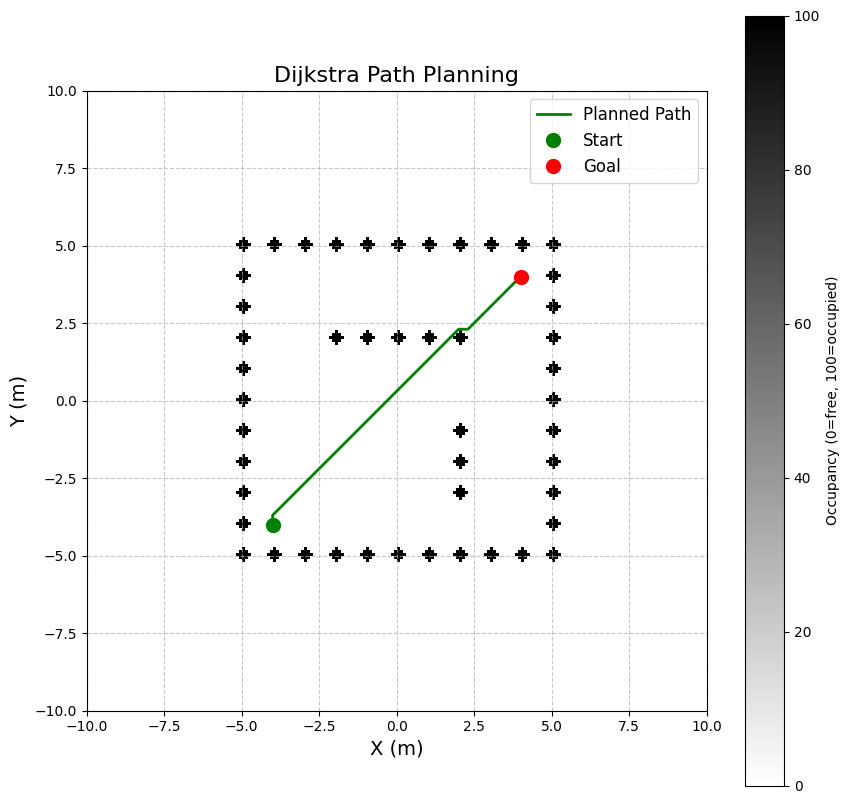

In [16]:
# Visualize the environment and path
plt.figure(figsize=(10, 10))

# Plot the grid
plt.imshow(planner.grid, cmap='binary', origin='lower', 
           extent=[planner.origin_x, planner.origin_x + planner.width * planner.resolution,
                  planner.origin_y, planner.origin_y + planner.height * planner.resolution])

# Plot the path
if path:
    path_x = [p[0] for p in path]
    path_y = [p[1] for p in path]
    plt.plot(path_x, path_y, 'g-', linewidth=2, label='Planned Path')
    plt.plot(path_x[0], path_y[0], 'go', markersize=10, label='Start')
    plt.plot(path_x[-1], path_y[-1], 'ro', markersize=10, label='Goal')

plt.title('Dijkstra Path Planning', fontsize=16)
plt.xlabel('X (m)', fontsize=14)
plt.ylabel('Y (m)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.colorbar(label='Occupancy (0=free, 100=occupied)')
plt.savefig("dijkstra_path.png", dpi=300)
plt.show()


## 9. Actual vs Predicted Path Visualization


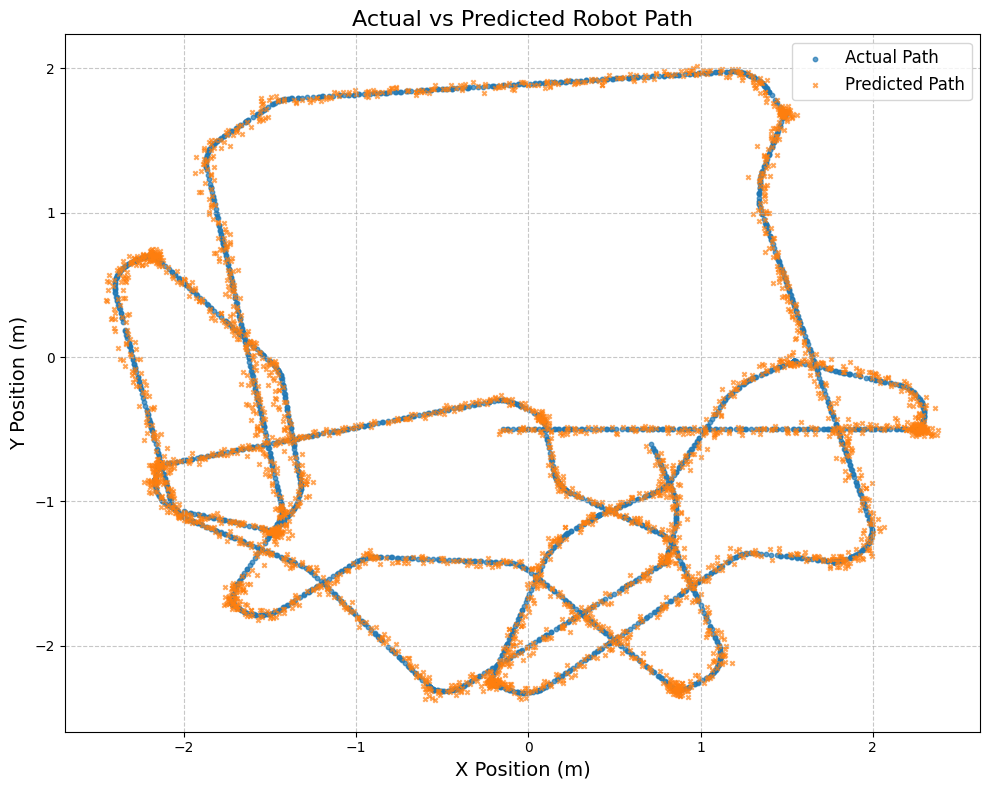

In [17]:
# Convert predicted and true values to numpy arrays
predicted_xy = np.array(predicted_xy)
true_xy = np.array(true_xy)

# Plot the actual vs predicted paths
plt.figure(figsize=(10, 8))
plt.scatter(true_xy[:, 0], true_xy[:, 1], label="Actual Path", s=10, alpha=0.7)
plt.scatter(predicted_xy[:, 0], predicted_xy[:, 1], label="Predicted Path", s=10, alpha=0.7, marker='x')
plt.title("Actual vs Predicted Robot Path", fontsize=16)
plt.xlabel("X Position (m)", fontsize=14)
plt.ylabel("Y Position (m)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig("actual_vs_predicted_path.png", dpi=300)
plt.show()


In [18]:
# Save the trained model
torch.save(model.state_dict(), "rnn_model.pt")
print("Model saved to rnn_model.pt")


Model saved to rnn_model.pt


## 10. Conclusion

# This notebook has demonstrated:
# 1. Implementation of an encoder-decoder RNN for predicting robot movement
# 2. Implementation of Dijkstra's algorithm for path planning
# 3. Visualization of loss curves during training
# 4. Comparison of actual vs predicted paths
# 
# The trained model and path planning algorithm can be used in a ROS2 environment for robot control.